# PRACTICAL 5: Constrained Optimization: Equality and Inequality Constraints

December 2024

Joel Dieguez (niub17087652) and Clàudia Valverde (niub20441186)

In [ ]:
from QPGC import QPGenericConstraints # using python 3.9

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Proposed Experiments

For the following experiments, it is interesting to plot the classification line at level lines 0, +1 and −1

Before running the experiments, we are going to create different functions that will serve us in executing the experiments.

- `dataset()`: generates a synthetic dataset of random points for the classification problem. The dataset's separability depends on the means nd covariances of the two classes. \
**What it does:** creates two Gaussian-distributed classes of data: \
m1 = [0.,0.] s1 = [[1,-0.9],[-0.9,1]] \
m2 = [3.,6.]  s2 = [[1,0],[0,1]] # Separable dataset \
m2 = [1.,2.]  s2 = [[1,0],[0,1]] # Non-separable dataset \
Finnally it combines points from both clases into $X$, a $2x2n$ matric, where the first dimension corresponds to $x_1, x_2$ and $y$, a vector of laels ($+1$ for positive class, $-1$ for negative class).

- `generation_matrices()`: geneates the matrices required to dfine the quadratic progamming (QP) problem for solving the SVM optimization. Returns the matrices $G, g, A, b, C, d,$ which represent the QP problem.

- `compute_w_b()`: computes the hyperplane parameters w and b based on the solution of the QP problem ($\alpha$)
Computes the weight vector $\mathbf{w}$ as:
$$
\mathbf{w} = \sum \alpha_i y_i \mathbf{x}_i
$$
Determines $b$ using one of the support vectors, ensuring the condition:
$$
y_i (\mathbf{w}^T \mathbf{x}_i + b) = 1
$$
is satisfied.
- Finally there are two plotting functions, the first one `plot_results()` is to plot individual plots of the resulting hyperplanes and the datapoints and the second one results in a 4x4 grid plot of the hyperplanes and datapoints.

In [ ]:
def dataset(n_points, separable = True):
    m1 = np.array([0., 0.])
    s1 = np.array([[1., -0.9], [-0.9, 1.]])
    if separable:
        m2 = np.array([3., 6.])
        s2 = np.array([[1., 0.], [0., 1.]])
    else:
        m2 = np.array([1., 2.])
        s2 = np.array([[1., 0.], [0., 1.]])

    pos_class = np.random.multivariate_normal(m1, s1, n_points)
    neg_class = np.random.multivariate_normal(m2, s2, n_points)
    x = np.concatenate((pos_class, neg_class)).T
    y = np.concatenate((np.ones(n_points), -1*np.ones(n_points)))

    return x,y


In [ ]:
def generation_matrices(x, y, K):
    # Dimensions
    n = x.shape[1]  # Number of points
    m = 2 * n       # Total inequality constraints
    p = 1           # Equality constraint dimension

    # Matrices construction
    G = np.dot(np.dot(np.diag(y), x.T), np.dot(x, np.diag(y)))  # Hessian
    g = -np.ones(n)                                             # Linear term
    A = y.reshape(n, p)                                         # Equality constraint
    b = np.zeros(p)                                             # Target sum zero
    C = np.concatenate((np.eye(n), -np.eye(n)), axis=1)         # Inequality constraint
    d = np.concatenate((np.zeros(n), -K * np.ones(n)))          # Bounds

    return G, g, A, b, C, d


In [ ]:
# Compute w and b
def compute_w_b(K, alpha, X, y):
    # Compute w
    w = np.sum(alpha * y * X, axis=1)

    # Compute b
    b_values = []
    for i in range(alpha.shape[0]):
        if 0 < alpha[i] < K:  # Support vectors (strict bounds)
            b_values.append(y[i] - np.dot(w.T, X[:, i]))
    b = np.median(b_values)  # Take the median for robustness

    return w, b

In [ ]:
# Plot the dataset and hyperplanes
def plot_results(X, y, w, b, title):
    plt.figure(figsize=(8, 6))
    # Plot points
    plt.scatter(X[0, :], X[1, :], c=y, cmap='bwr')

    # Plot decision boundary f(x) = 0
    x_vals = np.linspace(-10, 10, 100)

    y_vals = -(w[0] * x_vals + b) / w[1]
    plt.plot(x_vals, y_vals, "-", label="Decision Boundary (f(x) = 0)")

    # Plot f(x) = ±1
    y_vals_1 = -(w[0] * x_vals + b - 1) / w[1]
    y_vals_neg_1 = -(w[0] * x_vals + b + 1) / w[1]
    plt.plot(x_vals, y_vals_1, "--",  label="Margin (f(x) = +1)")
    plt.plot(x_vals, y_vals_neg_1, "--",  label="Margin (f(x) = -1)")

    plt.title(f"SVM Classification with Margins with K={title}")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid()
    plt.show()

In [ ]:
# Plot the dataset and hyperplanes for grid layout of the plots
def plot_svm(ax, X, y, w, b, title):
    # Scatter plot of points
    ax.scatter(X[0, :], X[1, :], c=y, cmap='bwr')

    # Plot decision boundary f(x) = 0
    x_vals = np.linspace(np.min(X[0, :]), np.max(X[0, :]), 100)
    y_vals = -(w[0] * x_vals + b) / w[1]
    ax.plot(x_vals, y_vals, "-", label="Decision Boundary (f(x) = 0)")

    # Plot f(x) = ±1
    y_vals_1 = -(w[0] * x_vals + b - 1) / w[1]
    y_vals_neg_1 = -(w[0] * x_vals + b + 1) / w[1]
    ax.plot(x_vals, y_vals_1, "--", label="Margin (f(x) = +1)")
    ax.plot(x_vals, y_vals_neg_1, "--", label="Margin (f(x) = -1)")

    # Titles and labels
    ax.set_title(f"K = {title}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    #ax.legend()
    ax.grid()

### Experiment 1
You are recommended to begin with the simplest case, i.e. the case in which data is separable, and with a small dataset (2 points for each class, for instance). You are recommended to start with a relatively small value of $K$, e.g. $K=1$. Plot the hyperplane $f(x) = w^T x + b=0$, as well as the hyperplane at distance $−1$ and $1$ respectively. Check if the hyperplane separates correctly the set of points and check that the hyperplanes at distance $−1$ and $1$ “touch” the support vectors.

**ANSWER:**

Biggest alpha: 5.129e-02


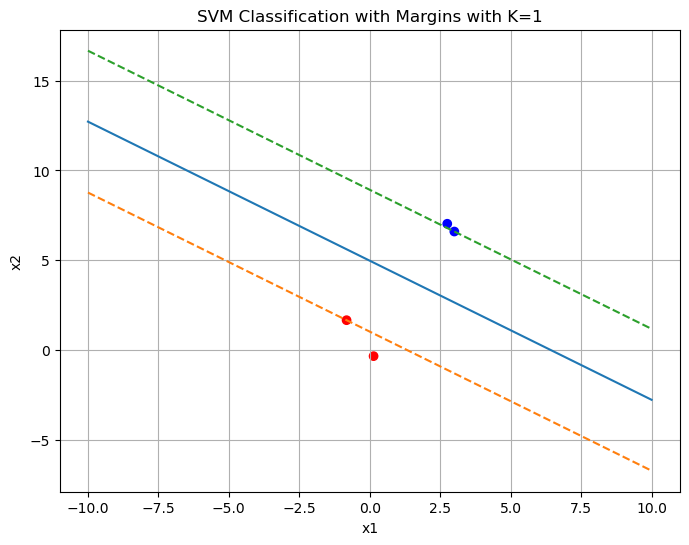

In [ ]:
X, y = dataset(2, separable = True)

G, g, A, b, C, d = generation_matrices(X, y, K=1)

# Solve the QP problem
alpha = QPGenericConstraints(G, g, A, C, b, d)

# Solution is the vector of Lagrange multipliers α
print("Biggest alpha: %.3e" % (max(alpha)))

w, b = compute_w_b(K=1, alpha=alpha, X=X, y=y)

plot_results(X, y, w, b, 1)

We are able to separate correctly the data, moreover, the hyperplanes at distance −1 and 1 touch one (or more) points respectively, which are known as **support vectors**.

### Experiment 2
Once it works, you may use a separable data set in which each class has 100 samples, for instance. Plot the obtained result and see if the hyperplane separates correctly the set of points.

**ANSWER:**

Biggest alpha: 2.728e-01


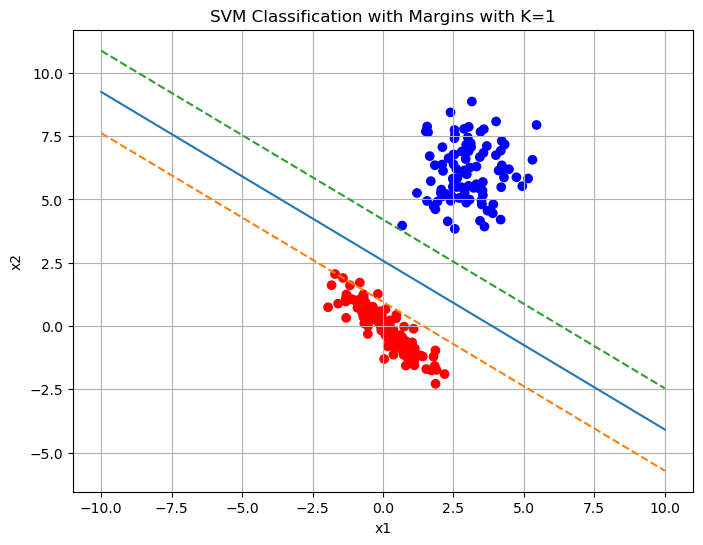

In [ ]:
X, y = dataset(100, separable = True)

G, g, A, b, C, d = generation_matrices(X, y, K=1)

# Solve the QP problem
alpha = QPGenericConstraints(G, g, A, C, b, d)

# Solution is the vector of Lagrange multipliers α
print("Biggest alpha: %.3e" % (max(alpha)))

w, b = compute_w_b(K=1, alpha=alpha, X=X, y=y)

plot_results(X, y, w, b, 1)

For a large dataset such as n=100 the classification between the two classes its still perfect.

### Experiment 3
Perform several experiments with different values of $K$ and test the stability of the solution you obtain. You may use small values of $K$, e.g. $K = 1$, as well as large values of $K$, e.g. $K = 10^6$ or higher such as $K = 10^{12}$. Repeat the experiment several times. Does the value of $K$ influence the solution you obtain? That is, does the hyperplane separate correctly the set of points you have? Can you explain the results? Recall that you are in the separable case, i.e. Eq (6) has no upper threshold for α.

**ANSWER:**

K=1, Biggest alpha: 1.606e-01
K=100, Biggest alpha: 3.513e-02
K=1000000.0, Biggest alpha: 1.158e-02
K=0.001, Biggest alpha: 1.000e-03


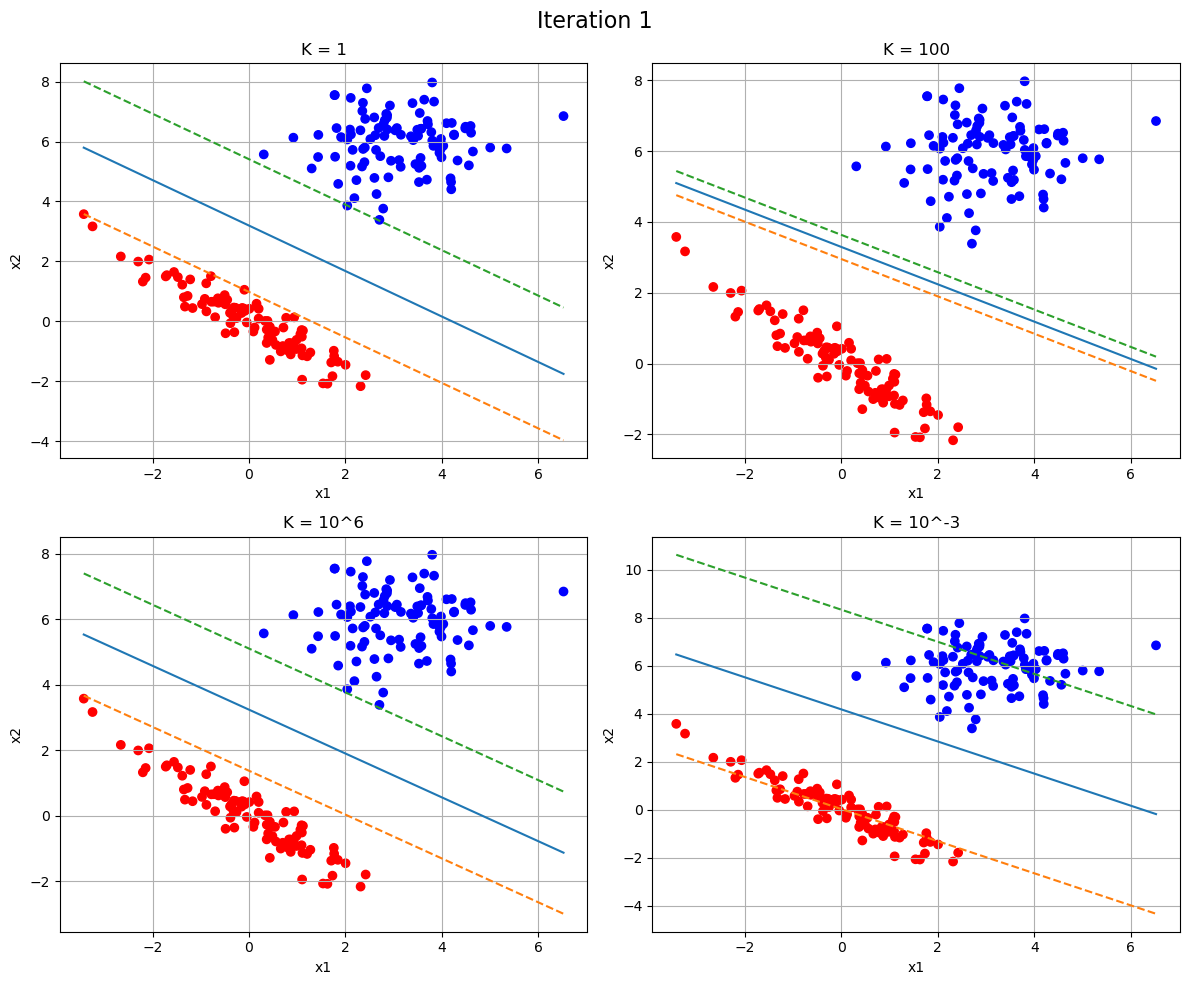

K=1, Biggest alpha: 1.470e-01
K=100, Biggest alpha: 1.587e-02
K=1000000.0, Biggest alpha: 1.396e-02
K=0.001, Biggest alpha: 1.000e-03


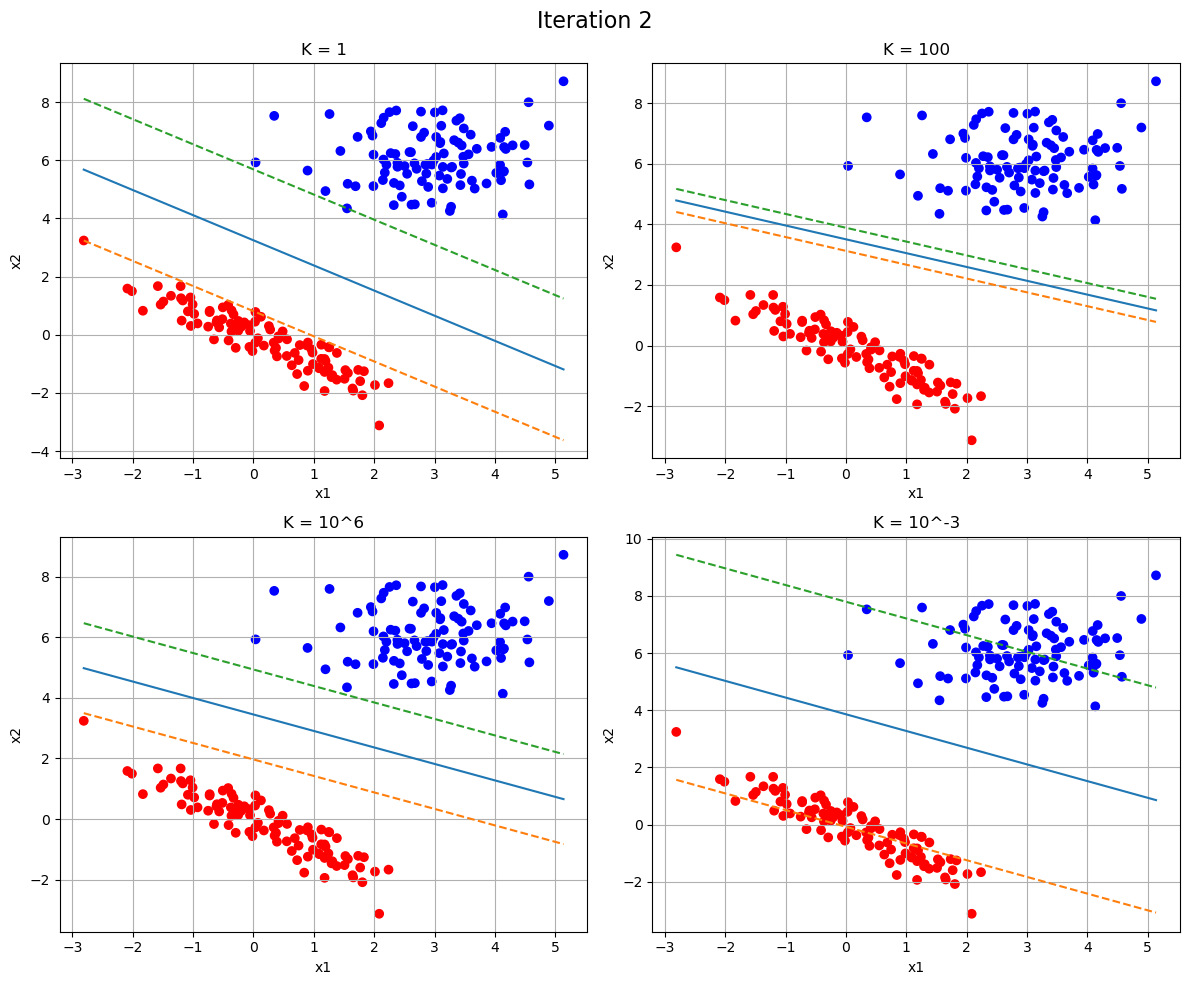

K=1, Biggest alpha: 2.330e-01
K=100, Biggest alpha: 6.423e-02
K=1000000.0, Biggest alpha: 1.466e+11
K=0.001, Biggest alpha: 1.000e-03


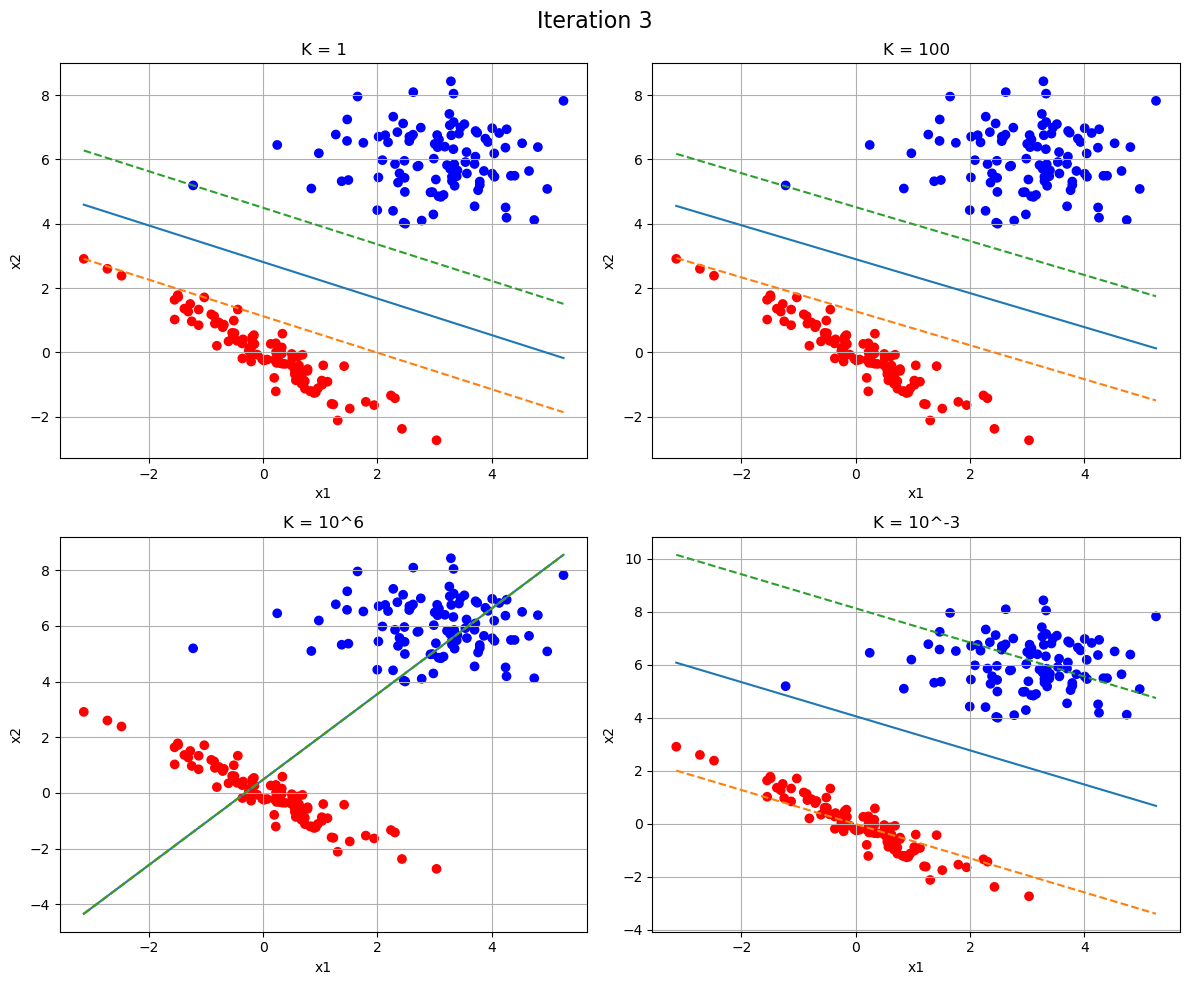

In [ ]:
# Iterate over the scenarios
K_values = [1, 100, 1e6, 1e-3]
titles = ["1", "100", "10^6", "10^-3"]

for iter in [1,2,3]:
    # Dataset
    X, y = dataset(100, separable=True)

    # Prepare the grid for 4 plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for i, (K, title) in enumerate(zip(K_values, titles)):

        # Generate matrices
        G, g, A, b, C, d = generation_matrices(X, y, K)

        # Solve the QP problem
        alpha = QPGenericConstraints(G, g, A, C, b, d)
        print(f"K={K}, Biggest alpha: %.3e" % (max(alpha)))


        # Compute w and b
        w, b = compute_w_b(K=K, alpha=alpha, X=X, y=y)

        # Plot results in the grid
        ax = axes[i // 2, i % 2]  # Determine subplot position
        plot_svm(ax, X, y, w, b, title)

    # Adjust layout and show the grid of plots
    fig.suptitle(f"Iteration {iter}", fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()


We would like the hyperplane separating the positive points from the negative to be as far apart as possible.


For very small K it seems as if the method does not work correctly, see that $K=10^{-3}$ the some classes are not fully well separated and the margins $+1, -1$ are not in the correct distance. When increasing $K$ the model works correctly (such as $K=1$ or $K=100$), if we continue to increase the method does not work as much, when $K=10^6$ of higher the method sometimes does not even converge.

### Experiment 4

Test your algorithm with the non-separable case using different values of $K$. Repeat the experiment several times. Again, does the value of $K$ influence the solution you obtain? Can you explain the results?

**ANSWER:**

Biggest alpha: 8.872e-01


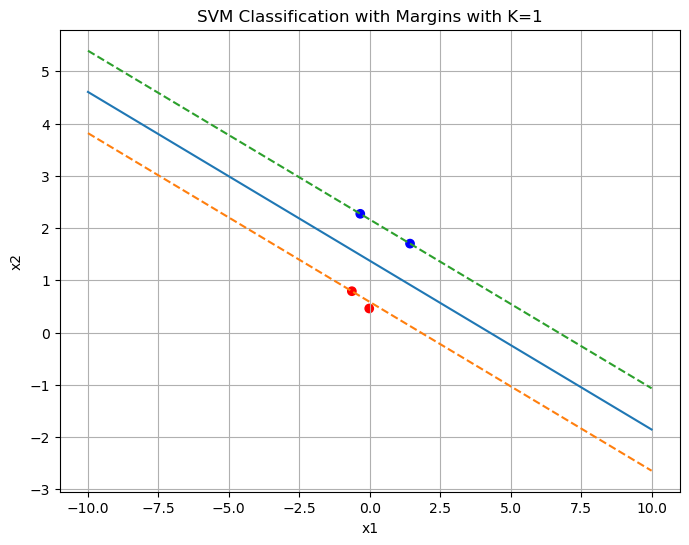

In [ ]:
X, y = dataset(2, separable = False)

G, g, A, b, C, d = generation_matrices(X, y, K=1)

# Solve the QP problem
alpha = QPGenericConstraints(G, g, A, C, b, d)

# Solution is the vector of Lagrange multipliers α
print("Biggest alpha: %.3e" % (max(alpha)))

w, b = compute_w_b(K=1, alpha=alpha, X=X, y=y)

plot_results(X, y, w, b, 1)

Biggest alpha: 1.000e+00


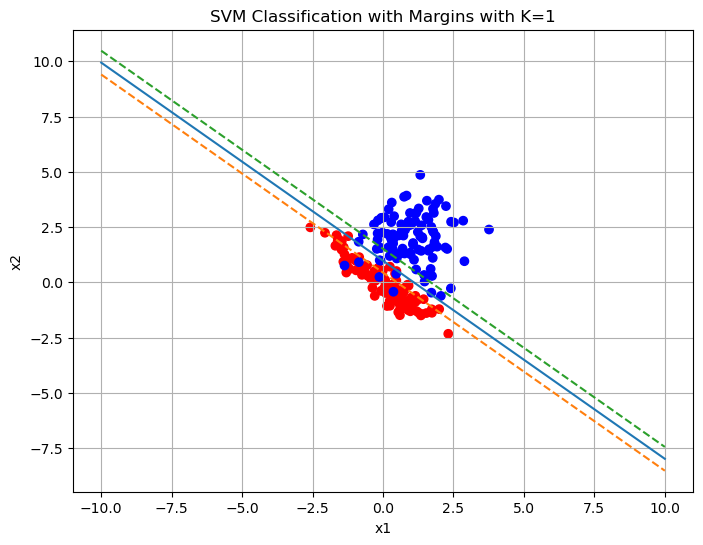

In [ ]:
X, y = dataset(100, separable = False)

G, g, A, b, C, d = generation_matrices(X, y, K=1)

# Solve the QP problem
alpha = QPGenericConstraints(G, g, A, C, b, d)
print("Biggest alpha: %.3e" % (max(alpha)))

w, b = compute_w_b(K=1, alpha=alpha, X=X, y=y)

plot_results(X, y, w, b, 1)

For a large dataset such as n=100

K=1, Biggest alpha: 1.000e+00
K=100, Biggest alpha: 1.000e+02
K=1000000.0, Biggest alpha: 1.457e+16
K=0.001, Biggest alpha: 1.000e-03


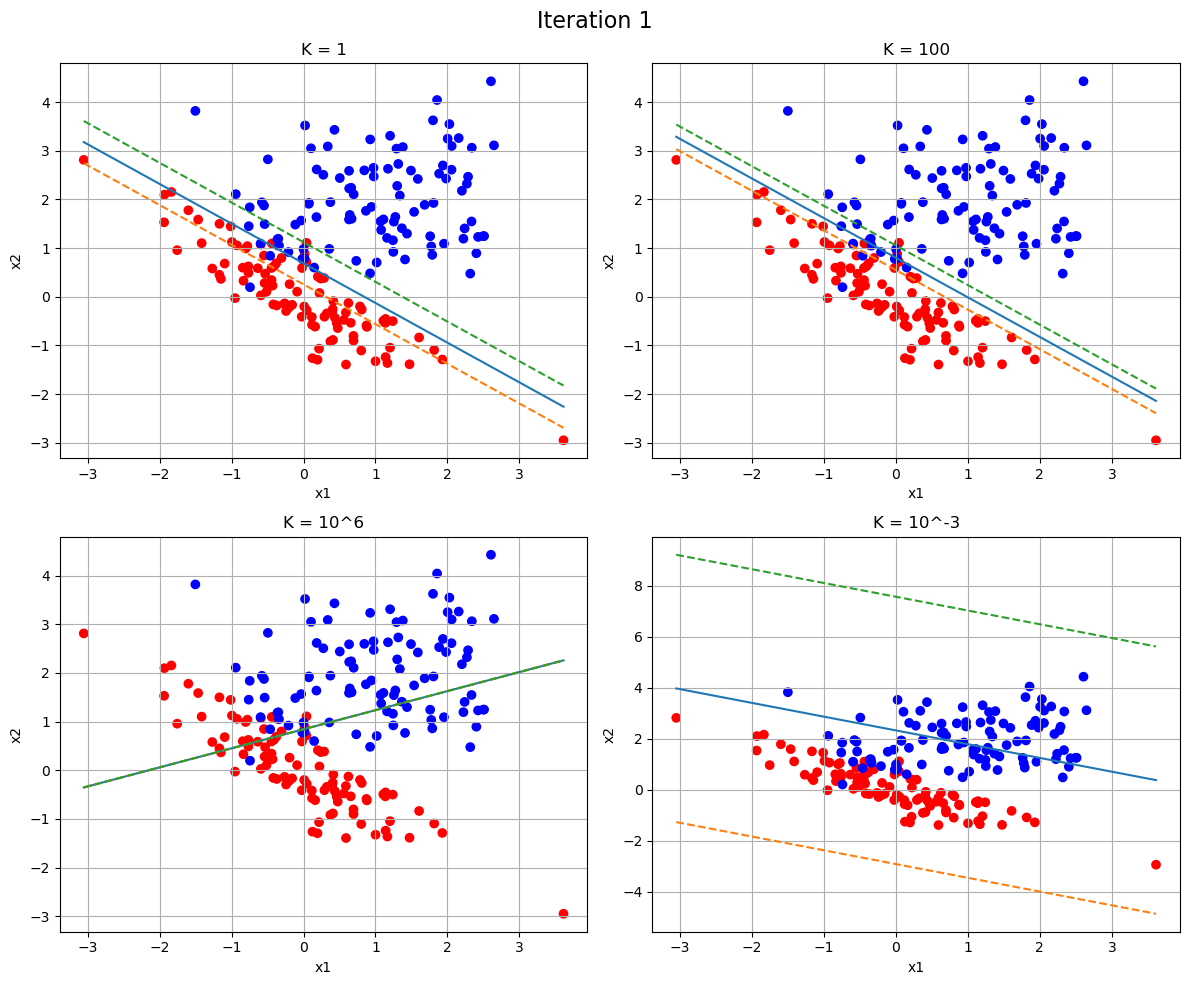

K=1, Biggest alpha: 1.000e+00
K=100, Biggest alpha: 9.933e+01
K=1000000.0, Biggest alpha: 1.000e+06
K=0.001, Biggest alpha: 1.000e-03


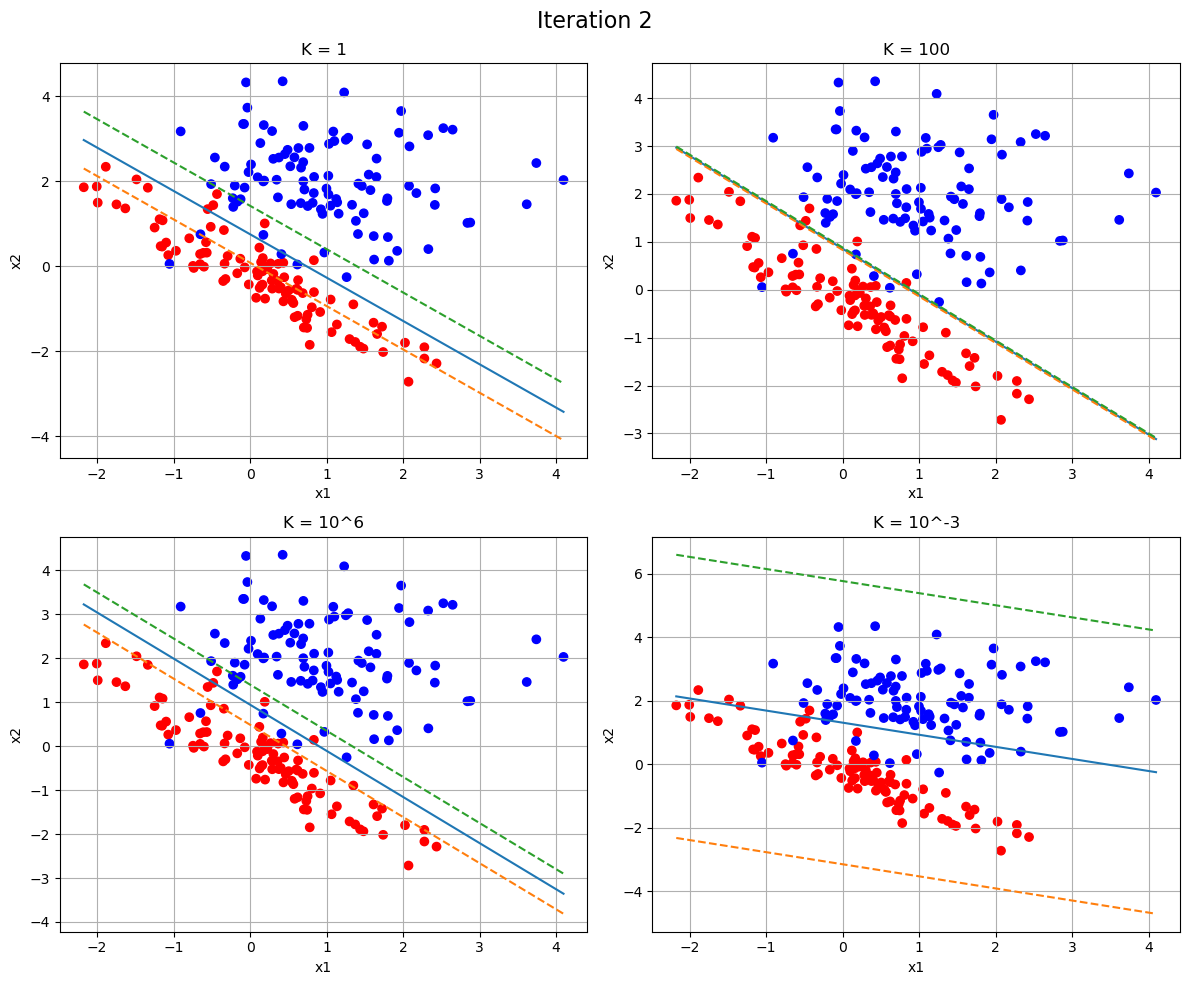

K=1, Biggest alpha: 1.000e+00
K=100, Biggest alpha: 1.000e+02
K=1000000.0, Biggest alpha: 4.158e+14
K=0.001, Biggest alpha: 1.000e-03


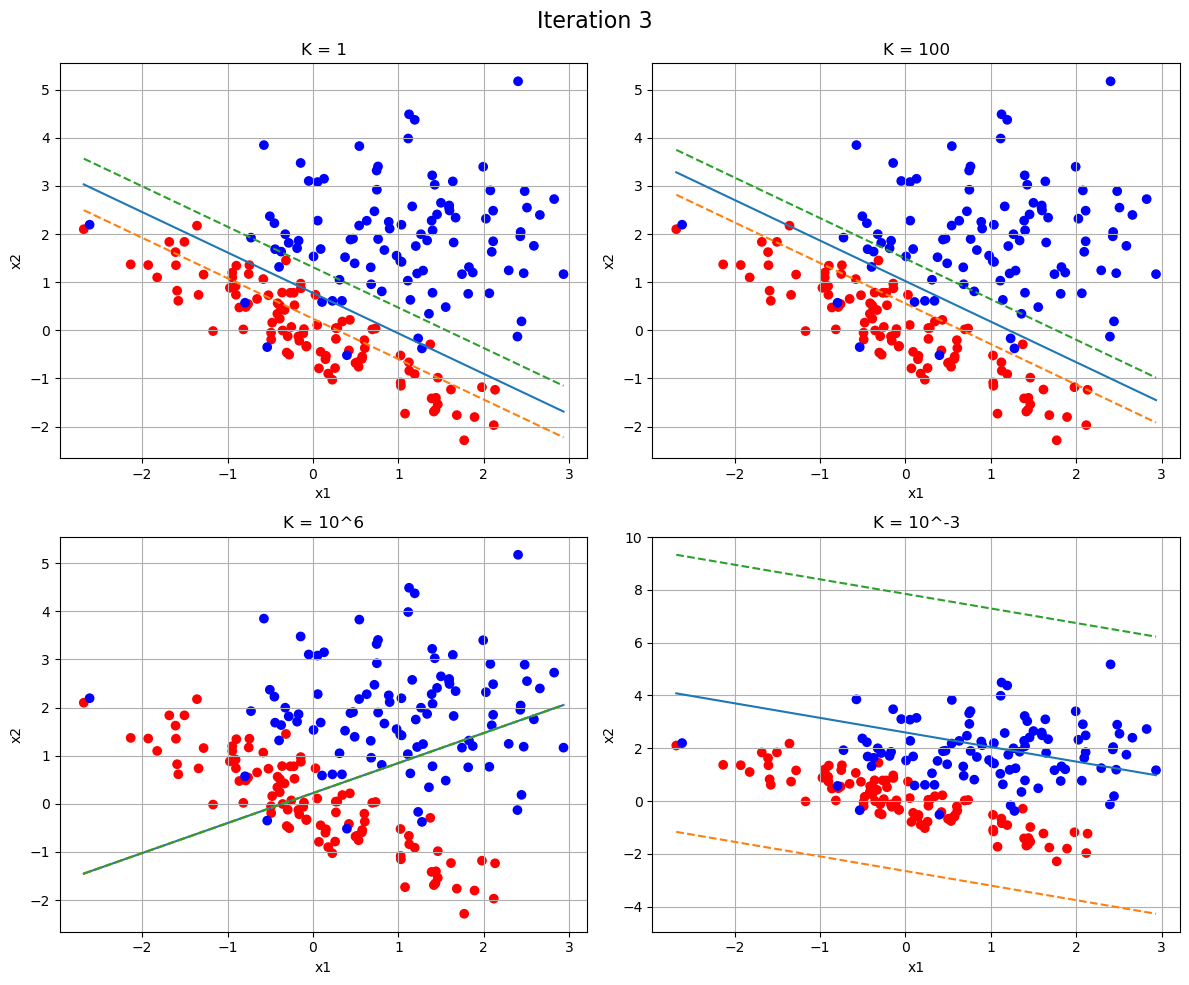

In [ ]:
# Iterate over the scenarios
K_values = [1, 100, 1e6, 1e-3]
titles = ["1", "100", "10^6", "10^-3"]

for iter in [1,2,3]:
    # Dataset
    X, y = dataset(100, separable=False)

    # Prepare the grid for 4 plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    for i, (K, title) in enumerate(zip(K_values, titles)):

        # Generate matrices
        G, g, A, b, C, d = generation_matrices(X, y, K)

        # Solve the QP problem
        alpha = QPGenericConstraints(G, g, A, C, b, d)
        print(f"K={K}, Biggest alpha: %.3e" % (max(alpha)))

        # Compute w and b
        w, b = compute_w_b(K=K, alpha=alpha, X=X, y=y)

        # Plot results in the grid
        ax = axes[i // 2, i % 2]  # Determine subplot position
        plot_svm(ax, X, y, w, b, title)

    # Adjust layout and show the grid of plots
    fig.suptitle(f"Iteration {iter}", fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()


In the non-separable case it seems that for very small $K$ ($K=10
^{-3}$) the method does not work as the hyperplane missclassifies lots of the points and the margins are not correct. It seems that the larger the value of $K$ the better the classification although it never reaches a perfect classification for a big dataset.